In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

In [4]:
clases = pd.read_csv('classes.csv')

In [5]:
clases_filtred = clases[clases['filename'].str.contains(r'^[a-zA-Z0-9_/\-.]+$', regex=True)]
clases_filtred['path'] = 'archive/' + clases_filtred['filename']

imagenes_random = clases_filtred['path'].sample(n=1000, random_state=42)

/var/folders/18/88x5gxxj0wq949rkr1_qj3_45113mn/T/ipykernel_52122/777794092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clases_filtred['path'] = 'archive/' + clases_filtred['filename']


Despues de varias pruebas y buscarle sentido a fitear el modelo con muchas imagenes, descubrí que no tiene sentido
ya que la idea es buscar los "centrides" de las imagenes y para eso solo se necesita una imagen a la vez por cada iteracion de entrenamiento.

In [6]:
images_random = clases_filtred['path'].sample(n=5)

In [7]:
images = []
for ima in  images_random:
    image = cv2.imread(ima)
    image_resized = cv2.resize(image, (224,224), interpolation=cv2.INTER_AREA)
    images.append(image_resized)

In [8]:
def silhouette(X, k_min=4, k_max=7):

    scores = []
    for i in range(k_min, k_max+1):
        
        model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        model_k.fit(X)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(X, model_k.labels_)
        scores.append(score)

    max_scores = max(scores)
    return scores.index(max_scores)+k_min
    

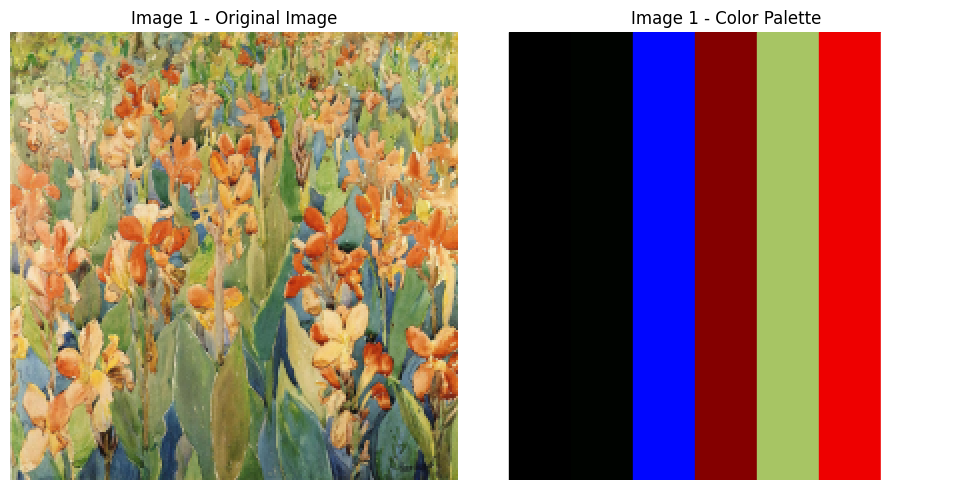

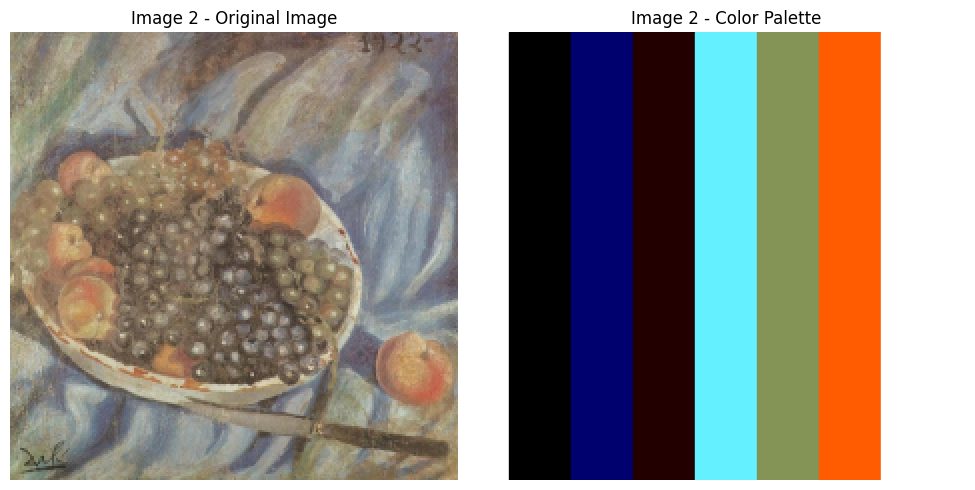

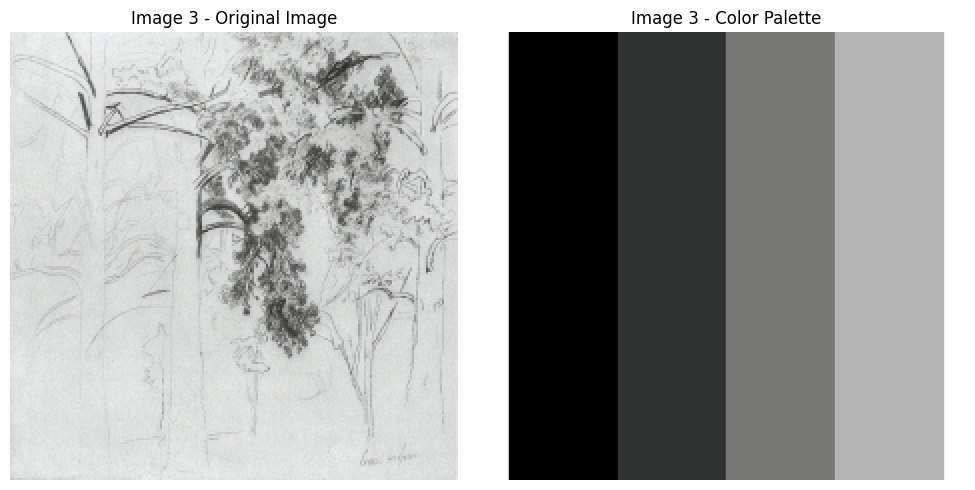

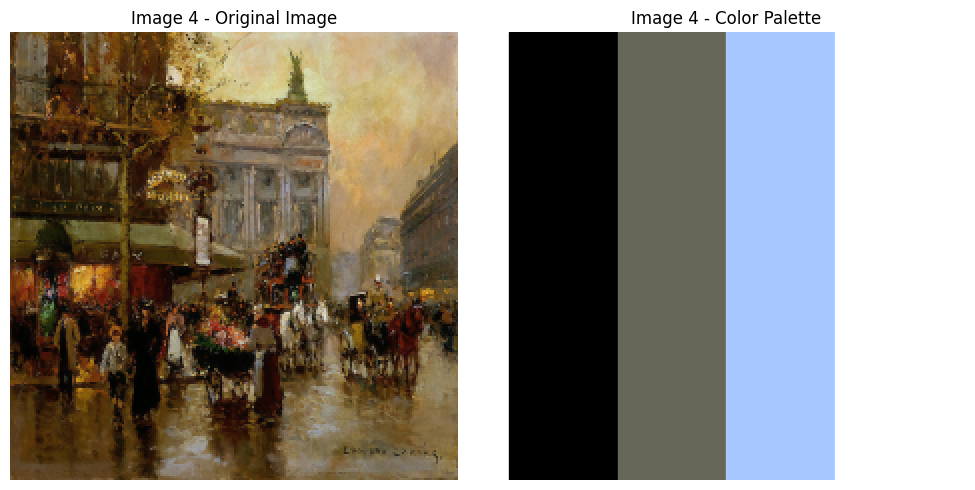

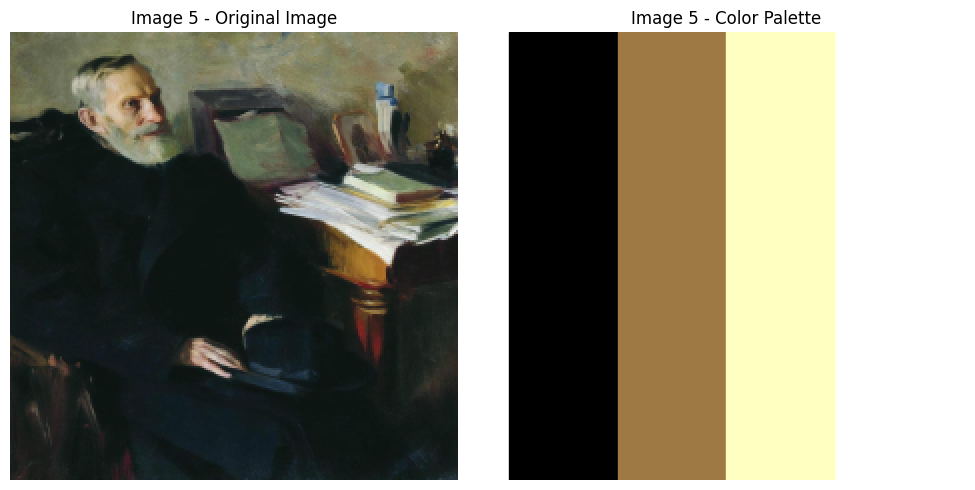

In [9]:
def show_image_and_palette(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
   
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{title} - Original Image")
    
    
    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    # no sirve
    #k_silhouette = silhouette(normalized_imag)

    kmeans = KMeans(n_clusters=8, random_state=42)


    kmeans.fit(normalized_imag)

    colors = kmeans.cluster_centers_
    colors = np.clip(colors * 255, 0, 255).astype(int)
    unque_colors = np.unique(colors, axis=0)
    #unque_colors = colors
    plt.subplot(1, 2, 2)
    for i, color in enumerate(unque_colors):
        plt.axvspan(i, i+1, color=color/255)
    #plt.xlim(0, len(colors))
    plt.axis('off')
    plt.title(f"{title} - Color Palette")
    
    plt.tight_layout()
    plt.show()

    return unque_colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)



In [129]:
#fin

In [95]:
palettes[0]

array([[255, 255, 255],
       [112, 131,  17],
       [255, 255,   0],
       [  0,   0,   0],
       [102, 138, 255],
       [  0,   0,   0]])

In [10]:
palettes[-1]

array([[  0,   0,   0],
       [158, 121,  68],
       [255, 255, 193],
       [255, 255, 255]])

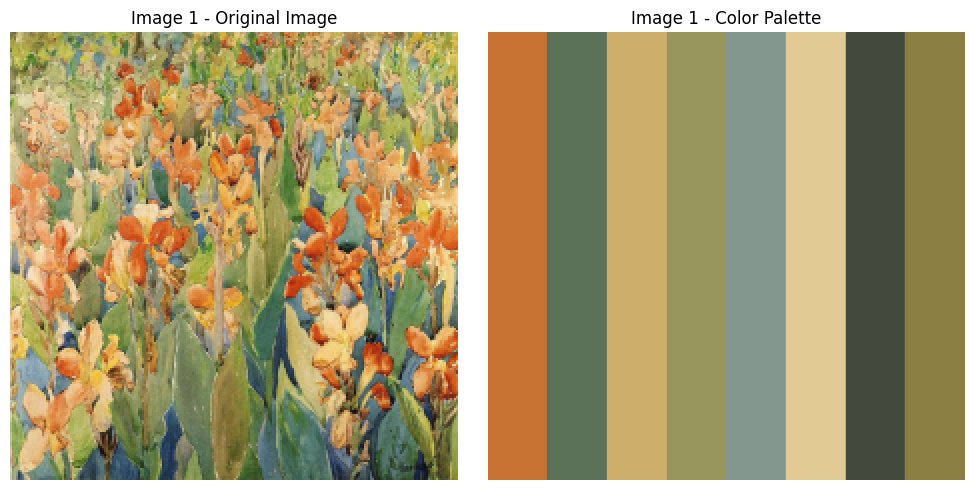

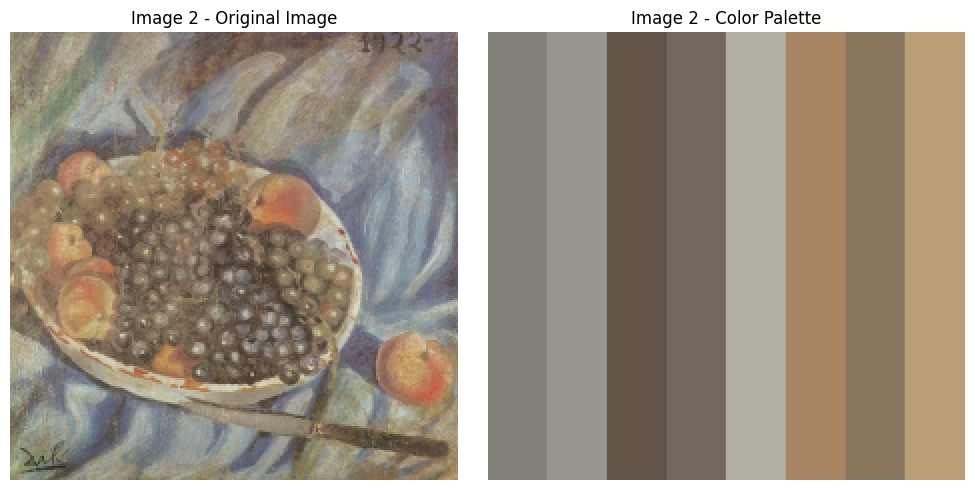

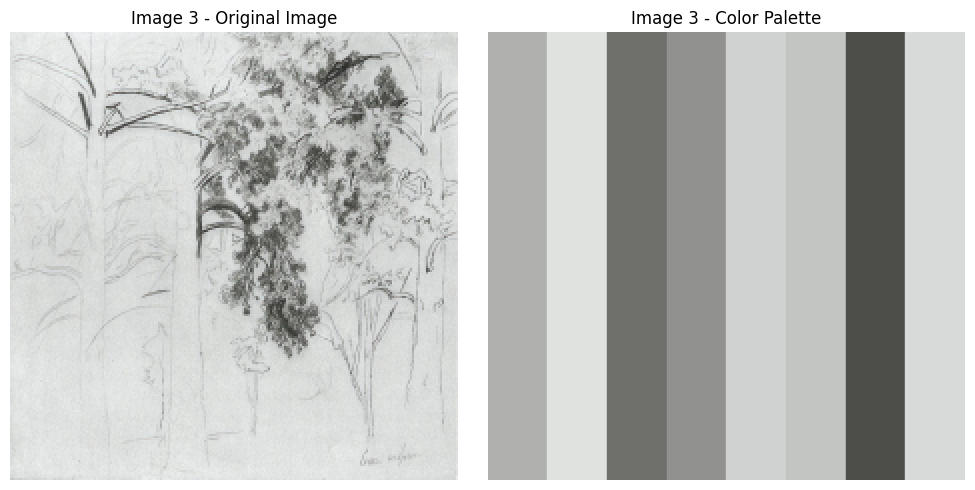

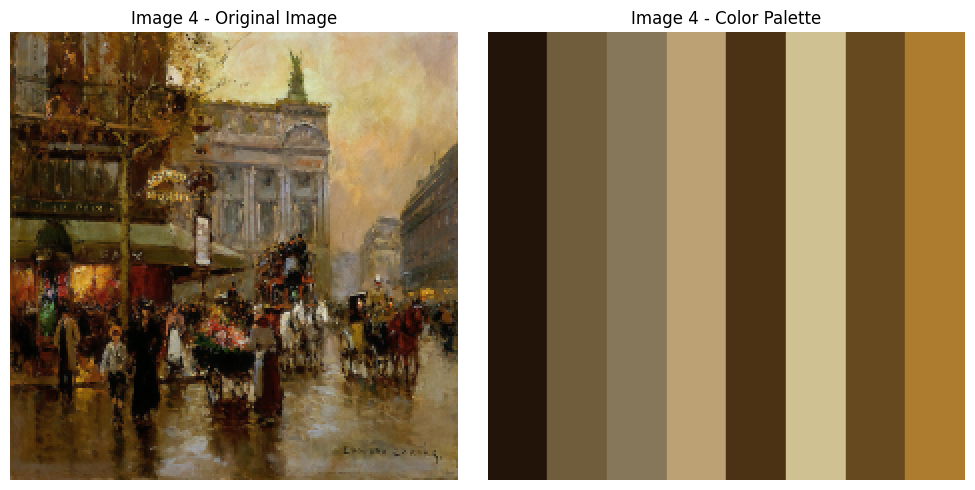

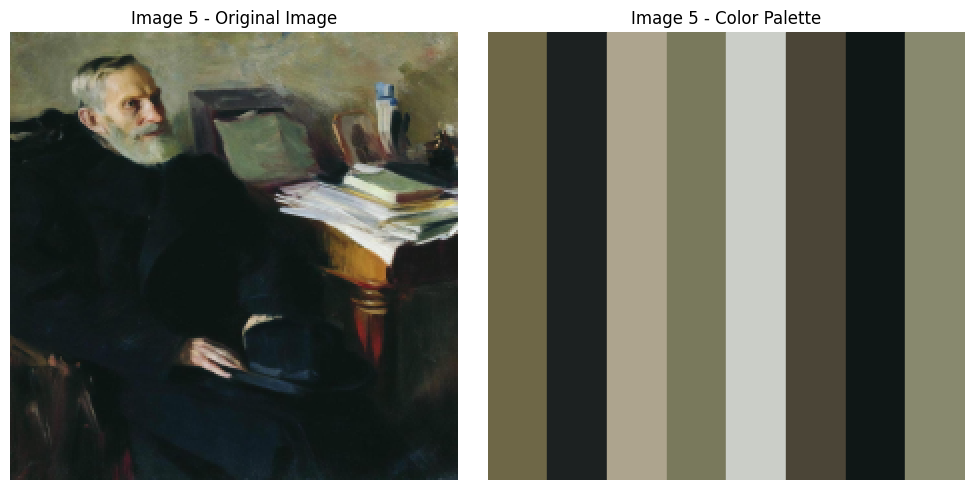

In [12]:
def show_image_and_palette(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
   
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{title} - Original Image")
    
    
    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    agglo = AgglomerativeClustering(n_clusters=8, linkage='ward')
    agglo.fit(normalized_imag)

    colors = []
    for i in range(8):
        cluster_pixels = ima[agglo.labels_ == i]
        avg_color = np.mean(cluster_pixels, axis=0)
        colors.append(avg_color)

    
    plt.subplot(1, 2, 2)
    for i, color in enumerate(colors):
        plt.axvspan(i, i+1, color=color/255)
    plt.xlim(0, len(colors))
    plt.axis('off')
    plt.title(f"{title} - Color Palette")
    
    plt.tight_layout()
    plt.show()

    return colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)